In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pyodbc
import sys
import urllib
from sqlalchemy import create_engine
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import statsmodels.api as sm
from collections import Counter

plt.style.use('seaborn-white')

%matplotlib inline

In [3]:
df_sales2019 = pd.read_csv("../data/p_store_order2019.csv", dtype={"orderno":str, "dcamount":int, "oriamount":int, "tamount":int})
df_sales2018 = pd.read_csv("../data/p_store_order2018.csv", dtype={"orderno":str, "dcamount":int, "oriamount":int, "tamount":int})

In [4]:
df_sales2019.head(2)

,orderno,branch,saledate,saletime,chk_cancel,dcamount,oriamount,tamount
0,201903140001,BK0008,20190314,1411,1,0,2300,2300
1,201904160001,BK0008,20190416,1224,1,0,3000,3000


In [5]:
# change setdate and saletime to datetime
def convert_dates(df):
    """
    converts saledate and saletime columns into one datetime datatype column
    
    Paremeters
    ==========
    df: Pandas DataFrame
    
    Returns
    =======
    df: Pandas Dataframe
        returns dataframe with new saledate column and drops old columns
    
    """
    df["saledate"] = df["saledate"].astype("str") + df["saletime"].astype("str").str.zfill(4)
    df["saledate"] = pd.to_datetime(df["saledate"], format='%Y%m%d%H%M')
    df.drop("saletime", axis=1, inplace=True)
    return df

In [6]:
# new dataframes with converted datetimes
df2019 = convert_dates(df_sales2019)
df2018 = convert_dates(df_sales2018)
df2019.head(1)

,orderno,branch,saledate,chk_cancel,dcamount,oriamount,tamount
0,201903140001,BK0008,2019-03-14 14:11:00,1,0,2300,2300


In [7]:
df2019.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1521588 entries, 0 to 1521587
Data columns (total 7 columns):
orderno       1521588 non-null object
branch        1521588 non-null object
saledate      1521588 non-null datetime64[ns]
chk_cancel    1521588 non-null int64
dcamount      1521588 non-null int64
oriamount     1521588 non-null int64
tamount       1521588 non-null int64
dtypes: datetime64[ns](1), int64(4), object(2)
memory usage: 81.3+ MB


In [8]:
def store_dataframe(df, interval):
    """
    Dataframe with datetime interval as rows and each store's tamount as columns.
    
    Parameters
    ==========
    df: Pandas DataFrame
        Dataframe output from convert_dates() 
    interval: str
        Label of the interval used to aggregate datetimes
        
    Returns
    =======
    Pandas DataFrame
        New aggregated DataFrame of the all stores and time interval
    """
    store_df = df.set_index('saledate')[["branch", "tamount"]]
    store_df = store_df.groupby("branch").resample(interval).sum()
    store_df = store_df["tamount"].unstack(level=0)#.astype('Int64')
    # drop rows from previous year
    value = store_df.index.year.value_counts().idxmax()
    store_df[store_df.index.year==value]
    return store_df[store_df.index.year==value].fillna(0)


In [14]:
# get df with all branches as column broken down to months
store_df = store_dataframe(df2019, "M")
store_df.head(2)

branch,BK0008,BK0010,BK0014,BK0016,BK0017,BK0018,BK0019,BK0020,BK0021,BK0022,...,BK0028,BK0029,BK1555,SWBK0006,SWSWBK0003,bk0009,bk0011,bk0016,bk0023,bk0026
saledate,,,,,,,,,,,,,,,,,,,,,
2019-01-31,0.0,27616850.0,32120850.0,9476600.0,17817090.0,49449650.0,73158360.0,52265470.0,6054100.0,23664400.0,...,0.0,0.0,19933100.0,53670950.0,50362100.0,15570500.0,49746750.0,0.0,0.0,0.0
2019-02-28,0.0,20143750.0,26576150.0,7328300.0,13183010.0,42068350.0,60155120.0,44193120.0,3955050.0,20222450.0,...,0.0,0.0,14902650.0,42085450.0,42372520.0,9675100.0,40029250.0,0.0,0.0,0.0


In [19]:
store_df.head()

branch,BK0008,BK0010,BK0014,BK0016,BK0017,BK0018,BK0019,BK0020,BK0021,BK0022,...,BK0028,BK0029,BK1555,SWBK0006,SWSWBK0003,bk0009,bk0011,bk0016,bk0023,bk0026
saledate,,,,,,,,,,,,,,,,,,,,,
2019-01-31,0.0,27616850.0,32120850.0,9476600.0,17817090.0,49449650.0,73158360.0,52265470.0,6054100.0,23664400.0,...,0.0,0.0,19933100.0,53670950.0,50362100.0,15570500.0,49746750.0,0.0,0.0,0.0
2019-02-28,0.0,20143750.0,26576150.0,7328300.0,13183010.0,42068350.0,60155120.0,44193120.0,3955050.0,20222450.0,...,0.0,0.0,14902650.0,42085450.0,42372520.0,9675100.0,40029250.0,0.0,0.0,0.0
2019-03-31,2300.0,23794500.0,34445750.0,12136200.0,18500140.0,50182400.0,75233910.0,66544330.0,5251800.0,24355050.0,...,0.0,0.0,17144000.0,63679500.0,52472420.0,31303700.0,46045450.0,0.0,0.0,0.0
2019-04-30,3000.0,25440300.0,38331200.0,13343800.0,21088580.0,52066800.0,73853400.0,74502530.0,6195200.0,27481550.0,...,0.0,0.0,20517000.0,69185050.0,57099560.0,39107450.0,48026550.0,0.0,0.0,0.0
2019-05-31,0.0,26134550.0,35974150.0,13066400.0,17538520.0,48597450.0,70697040.0,74445240.0,5552100.0,29433750.0,...,0.0,0.0,17937350.0,77582900.0,59159590.0,34896550.0,44018650.0,0.0,0.0,0.0


In [20]:
def saledate_decomp(df):
    """
    Decompose the saledate column into sub-components of time delta.
    
    Parameters
    ==========
    df: Pandas DataFrame
        Dataframe output from convert_dates() 
    
    Returns
    =======
    Pandas DataFrame
        New dataframe with decomposed salesdate columns appended   
    """
    
    df_new = df[["branch", "saledate", "tamount"]].copy()
    df_new["year"] = df_new["saledate"].dt.year
    df_new["month"] = df_new["saledate"].dt.month
    df_new["day"] = df_new["saledate"].dt.day
    df_new["hour"] = df_new["saledate"].dt.hour
    df_new["minute"] = df_new["saledate"].dt.minute
    df_new["day_of_week"] = df_new["saledate"].dt.dayofweek
    value = df_new["year"].value_counts().idxmax()
    del df_new["saledate"]
    return df_new[df_new["year"]==value] # exclude pre-year dates

In [21]:
test = saledate_decomp(df2019)
test.head()

,branch,tamount,year,month,day,hour,minute,day_of_week
0,BK0008,2300,2019,3,14,14,11,3
1,BK0008,3000,2019,4,16,12,24,1
2,BK0008,4600,2019,6,11,17,56,1
3,BK0008,4000,2019,6,24,17,9,0
4,BK0008,5100,2019,6,24,17,13,0


In [22]:
def weekly_average_series(df, STORE_CODE):
    """
    Calculates the average for each day of the week for one store. 
    
    Parameters
    ==========
    df: Pandas DataFrame
        Dataframe output from convert_dates() 
    STORE_CODE: str
        Store ID number
    
    Returns
    =======
    Pandas Series
        Average for each day of the week
    
    """
    # get daily sales of store
    store_series = store_dataframe(df, "D")[STORE_CODE]
    # get count of each dayofweek in year
    c = Counter(store_series.index.dayofweek)
    count = np.array([x[1] for x in sorted(c.items())]) # convert to allow numpy broadcasting
    weekly_average = store_series.groupby(store_series.index.weekday).sum() / count
    return weekly_average

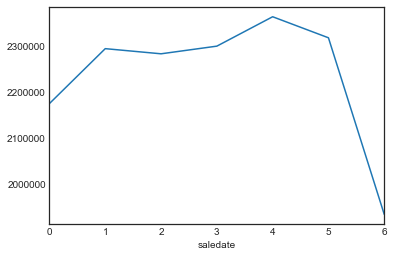

In [23]:
wk = weekly_average_series(df2019, "BK0019")
wk.plot()

In [24]:
def weekly_average_dataframe(df):
    """
    Combines series from weekly_average_series() into one dataframe.
    
    Parameters
    ==========
    df: Pandas DataFrame
        Dataframe output from convert_dates() 
    
    Returns
    =======
    Pandas DataFrame
        Average for each day of the week
    
    """
    branches = df["branch"].unique() # prepare branch columns
    d = {branch:weekly_average_series(df, branch) for branch in branches} # dictionary of series
    weekly_df = pd.DataFrame.from_dict(d)
    return weekly_df

In [25]:
test = weekly_average_dataframe(df2019)
test.astype("int64") # convert values to be more readable

,BK0008,bk0009,BK0010,bk0011,BK0014,BK0016,bk0016,BK0017,BK0018,BK0019,...,bk0023,BK0024,BK0025,bk0026,BK0027,BK0028,BK0029,BK1555,SWBK0006,SWSWBK0003
saledate,,,,,,,,,,,,,,,,,,,,,
0,11088,1132242,909951,1376411,1253250,369771,195283,720871,1533688,2175744,...,267484,274047,168246,93598,227593,45898,58359,780455,2497766,1924774
1,14298,1177607,969297,1416119,1380430,394618,203606,725062,1513648,2295072,...,292654,285437,169362,85057,252044,54885,42709,818156,2646724,2023391
2,9688,1134811,936802,1460990,1317250,381542,185490,712264,1550224,2283881,...,273378,235280,155636,87140,245137,62072,34497,814623,2586514,2017265
3,6261,1127697,962629,1429077,1326230,373638,193804,713899,1550393,2300521,...,249513,261485,145784,80033,253372,62372,39534,765525,2614631,2038346
4,5901,994776,996383,1504214,1391305,350488,198086,730341,1606054,2364433,...,281126,276775,165281,81960,272853,67267,47531,793259,2694807,2011809
5,11876,385533,821498,1467371,948363,90661,158650,204208,1412880,2318684,...,176185,98980,119197,97958,282135,82545,34392,60560,1369692,612750
6,15140,13827,0,945770,0,0,161720,0,1104572,1934733,...,30664,0,8806,98313,212666,57219,0,0,0,588179


In [26]:
df = store_dataframe(df2019, "30Min")

In [27]:
df["BK0019"]

saledate
2019-01-01 00:00:00        0.0
2019-01-01 00:30:00        0.0
2019-01-01 01:00:00        0.0
2019-01-01 01:30:00        0.0
2019-01-01 02:00:00        0.0
                        ...   
2019-12-31 20:30:00    27200.0
2019-12-31 21:00:00    35200.0
2019-12-31 21:30:00        0.0
2019-12-31 22:00:00        0.0
2019-12-31 22:30:00        0.0
Name: BK0019, Length: 17518, dtype: float64

In [28]:
def plot_store_by_interval(ax, df, STORE_CODE, interval):
    series = store_dataframe(df,interval)[STORE_CODE]
    ax.plot(series)
    ax.set_title(f"Trend for {STORE_CODE}")

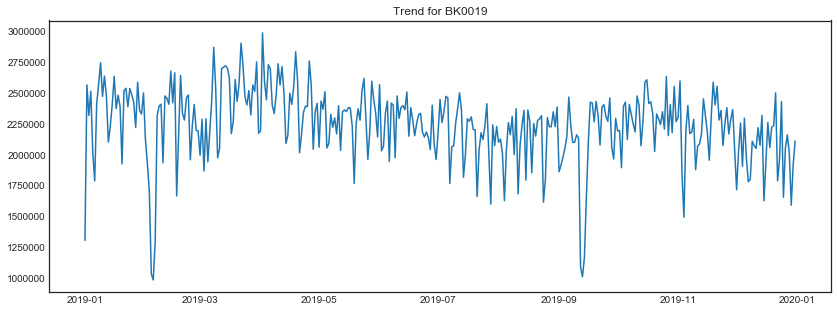

In [29]:
fig, ax = plt.subplots(figsize=(14,5))
plot_store_by_interval(ax, df2019, "BK0019", "D")

In [30]:
def plot_series(ax, series, title):
    ax.plot(series)
    ax.set_title(f"Trend For {title}")

def add_const(arr):
    return sm.add_constant(arr.reshape(-1, 1), prepend=False)

def fit_linear_trend(series):
    X = add_const(np.arange(len(series)) + 1)
    linear_trend_ols = sm.OLS(series.values, X).fit()
    linear_trend = linear_trend_ols.predict(X)
    return linear_trend

def plot_linear_trend(store_df, STORE_CODE):
    series = store_df[STORE_CODE]
    linear_trend = fit_linear_trend(series)
    plot_series(ax, series, STORE_CODE)
    ax.plot(series.index.date, linear_trend)

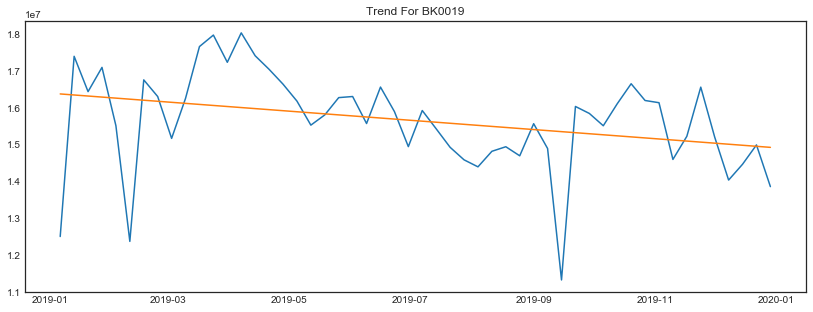

In [31]:
store_df1 = store_dataframe(df2019, "W")
fig, ax = plt.subplots(figsize=(14,5))
plot_linear_trend(store_df1, "BK0019")

In [32]:
def fit_moving_average_trend(series, window=6):
        return series.rolling(window, center=True).mean()
    
def plot_ma_trend(ax, store_df, STORE_CODE, window=6):
    series = store_df[STORE_CODE]
    ma = fit_moving_average_trend(series, window)
    plot_series(ax, series, STORE_CODE)
    ax.plot(ma)

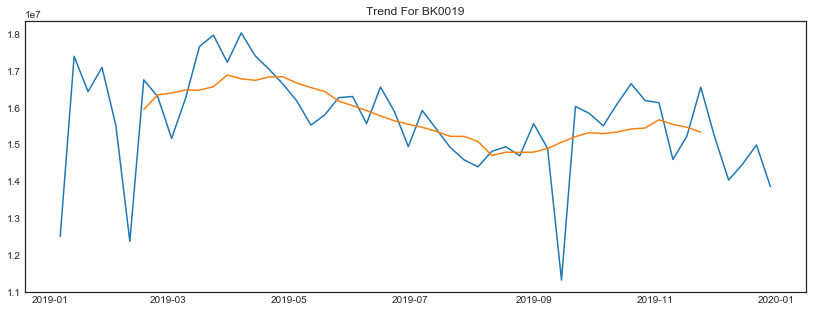

In [33]:
fig, ax = plt.subplots(figsize=(14,5))
plot_ma_trend(ax, store_df1, "BK0019", window=12)
    

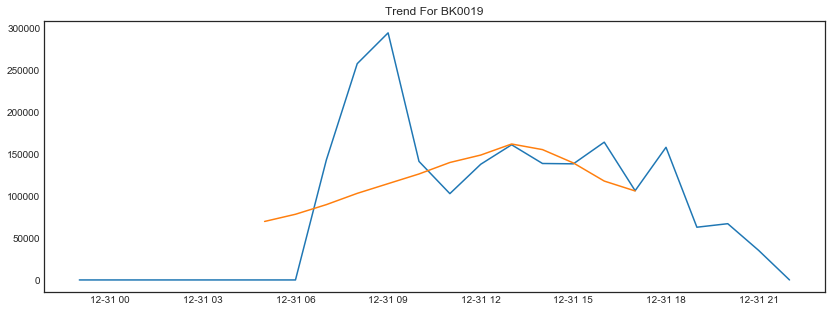

In [34]:
store_df7 = store_dataframe(df2019, "H")
store_df7 = store_df7.last("1D")

fig, ax = plt.subplots(figsize=(14,5))
plot_ma_trend(ax, store_df7, "BK0019", window=12)

In [35]:
def plot_shared_yscales(axs, x, ys, titles):
    ymiddles =  [ (y.max()+y.min())/2 for y in ys ]
    yrange = max( (y.max()-y.min())/2 for y in ys )
    for ax, y, title, ymiddle in zip(axs, ys, titles, ymiddles):
        ax.plot(x, y)
        ax.set_title(title)
        ax.set_ylim((ymiddle-yrange, ymiddle+yrange))
        
def plot_seasonal_decomposition(axs, store_df, STORE_CODE, view, freq):
    series = store_df[STORE_CODE].last(view)
    sd = sm.tsa.seasonal_decompose(series, freq=freq)
    plot_shared_yscales(axs,
                        series.index,
                        [series, sd.trend, sd.seasonal, sd.resid],
                        ["Raw Series", 
                         "Trend Component $T_t$", 
                         "Seasonal Component $S_t$",
                         "Residual Component $R_t$"])
    return sd

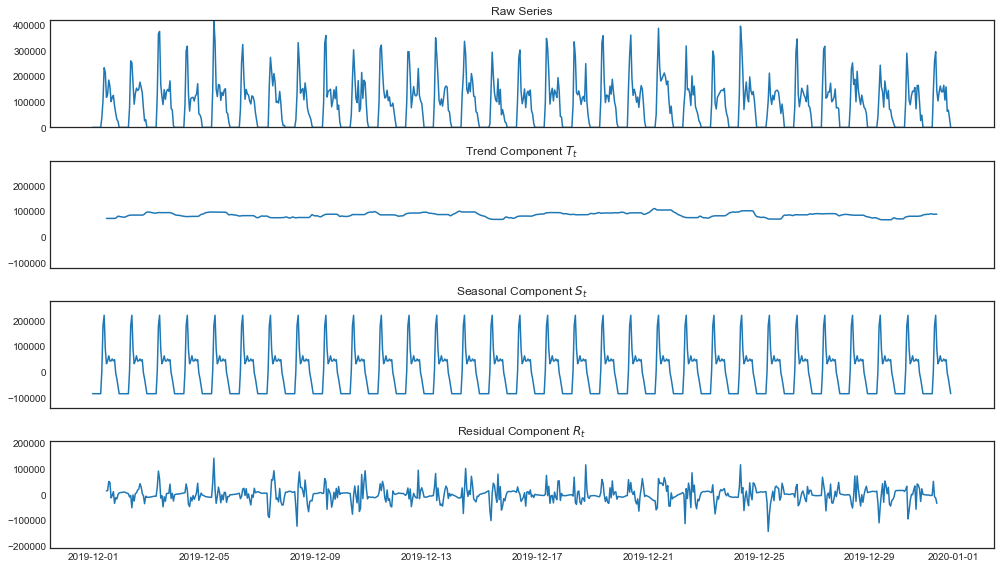

In [36]:
fig, axs = plt.subplots(4, figsize=(14, 8), sharex=True)
sd = plot_seasonal_decomposition(axs, 
                                 store_dataframe(df2019, "H"), 
                                 "BK0019",
                                 view="1M",
                                 freq=24)
plt.tight_layout()

In [37]:
sd.resid.fillna(0)

saledate
2019-11-30 23:00:00    0.0
2019-12-01 00:00:00    0.0
2019-12-01 01:00:00    0.0
2019-12-01 02:00:00    0.0
2019-12-01 03:00:00    0.0
                      ... 
2019-12-31 18:00:00    0.0
2019-12-31 19:00:00    0.0
2019-12-31 20:00:00    0.0
2019-12-31 21:00:00    0.0
2019-12-31 22:00:00    0.0
Name: BK0019, Length: 744, dtype: float64

In [38]:
# Augmented Dickey_fuller test
sd_resid = sd.resid.fillna(0)
test = sm.tsa.stattools.adfuller(sd_resid)
print("ADF p-value: {0:.7f}".format(test[1]))

ADF p-value: 0.0000000


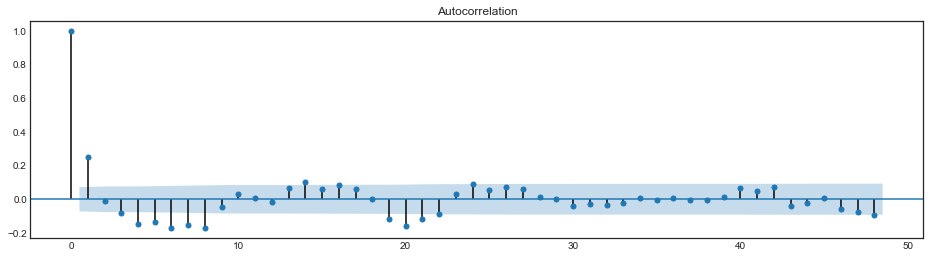

In [39]:
# Autocorrelation on residuals
fig, ax = plt.subplots(1, figsize=(16, 4))
_ = sm.graphics.tsa.plot_acf(sd_resid, lags=2*24, ax=ax)

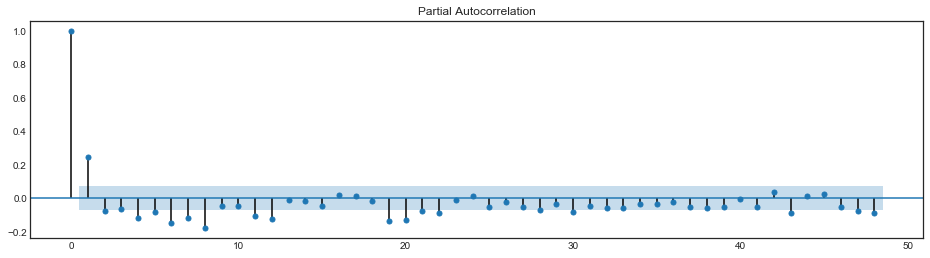

In [40]:
# Partial Autocorrelation on residuals
fig, ax = plt.subplots(1, figsize=(16, 4))
_ = sm.graphics.tsa.plot_pacf(sd_resid, lags=2*24, ax=ax)

In [41]:
store_df_hourly = store_dataframe(df2019, "H")

In [42]:
d = store_df_hourly["BK0019"].last("7D")
df.index

DatetimeIndex(['2019-01-01 00:00:00', '2019-01-01 00:30:00',
               '2019-01-01 01:00:00', '2019-01-01 01:30:00',
               '2019-01-01 02:00:00', '2019-01-01 02:30:00',
               '2019-01-01 03:00:00', '2019-01-01 03:30:00',
               '2019-01-01 04:00:00', '2019-01-01 04:30:00',
               ...
               '2019-12-31 18:00:00', '2019-12-31 18:30:00',
               '2019-12-31 19:00:00', '2019-12-31 19:30:00',
               '2019-12-31 20:00:00', '2019-12-31 20:30:00',
               '2019-12-31 21:00:00', '2019-12-31 21:30:00',
               '2019-12-31 22:00:00', '2019-12-31 22:30:00'],
              dtype='datetime64[ns]', name='saledate', length=17518, freq=None)

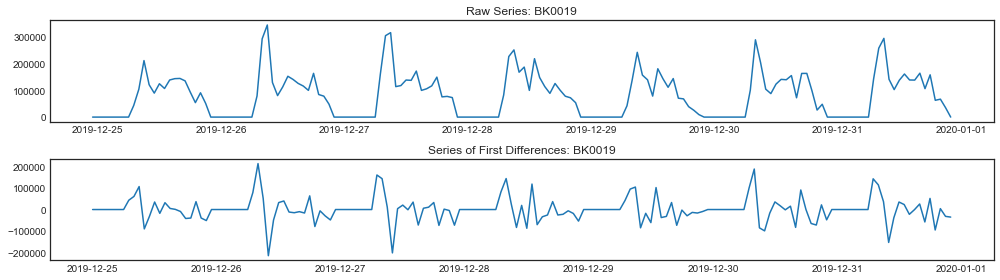

In [43]:
def plot_series_and_difference(axs, series, title):
    diff = series.diff()
    axs[0].plot(series)
    axs[0].set_title("Raw Series: {}".format(title))
    axs[1].plot(diff)
    axs[1].set_title("Series of First Differences: {}".format(title))


fig, axs = plt.subplots(2, figsize=(14, 4))
plot_series_and_difference(axs, store_df_hourly["BK0019"].last("7D"), 'BK0019')
fig.tight_layout()

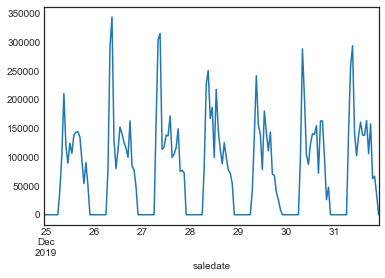

In [44]:
store_df_hourly["BK0019"].last("7D").plot()

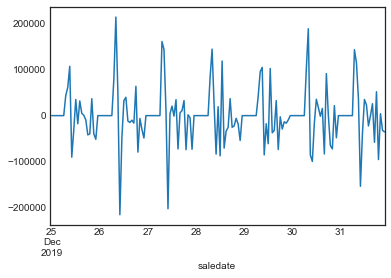

In [45]:
store_df_hourly["BK0019"].last("7D").diff().plot()

In [46]:
# Augmented Dickey_fuller test
test1 = sm.tsa.stattools.adfuller(store_df_hourly["BK0019"].last("7D").diff().fillna(0))
print("ADF p-value: {0:.7f}".format(test1[1]))

ADF p-value: 0.0000000


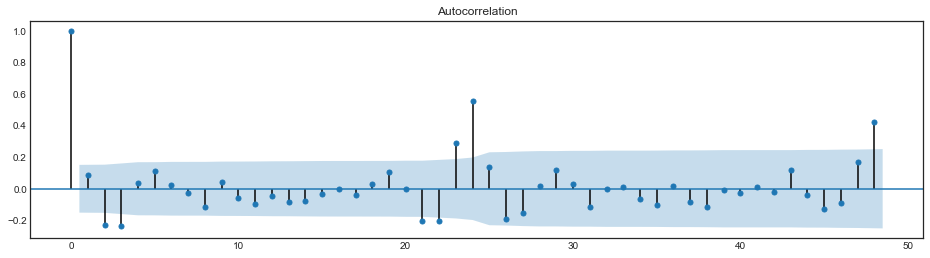

In [47]:
# Autocorrelation on diff
fig, ax = plt.subplots(1, figsize=(16, 4))
_ = sm.graphics.tsa.plot_acf(store_df_hourly["BK0019"].last("7D").diff().fillna(0), lags=2*24, ax=ax)

/Users/chulgyukim/opt/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1358: RuntimeWarning:

invalid value encountered in sqrt



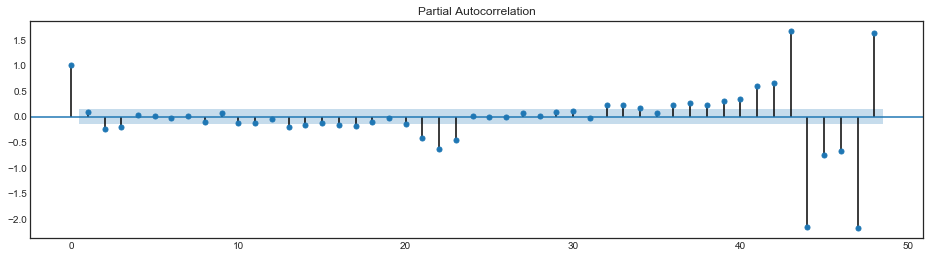

In [48]:
# Partial Autocorrelation on diff
fig, ax = plt.subplots(1, figsize=(16, 4))
_ = sm.graphics.tsa.plot_pacf(store_df_hourly["BK0019"].last("7D").diff().fillna(0), lags=2*24, ax=ax)

In [49]:
from fbprophet import Prophet

In [50]:
store_df_hourly["BK0019"]

saledate
2019-01-01 00:00:00         0.0
2019-01-01 01:00:00         0.0
2019-01-01 02:00:00         0.0
2019-01-01 03:00:00         0.0
2019-01-01 04:00:00         0.0
                         ...   
2019-12-31 18:00:00    158000.0
2019-12-31 19:00:00     62800.0
2019-12-31 20:00:00     67000.0
2019-12-31 21:00:00     35200.0
2019-12-31 22:00:00         0.0
Name: BK0019, Length: 8759, dtype: float64

In [133]:
df = store_df_hourly["BK0019"].last("M").reset_index()
df
df.columns = ["ds", "y"]
df.tail()

,ds,y
739,2019-12-31 18:00:00,158000.0
740,2019-12-31 19:00:00,62800.0
741,2019-12-31 20:00:00,67000.0
742,2019-12-31 21:00:00,35200.0
743,2019-12-31 22:00:00,0.0


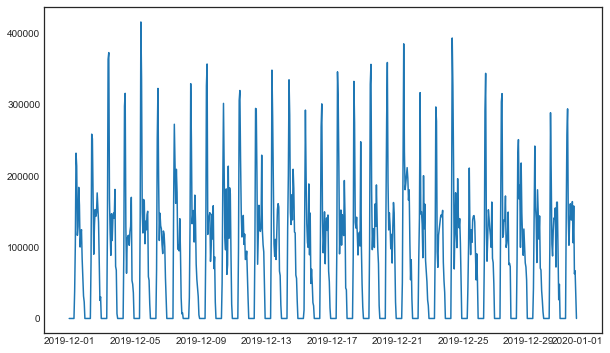

In [52]:
fig = plt.figure(facecolor='w', figsize=(10, 6))
plt.plot(df.ds, df.y)

In [53]:
def fb_prophet(df, store_hours=None):
    """
    Quick facebook prophet plot
    
    Parameters
    ==========
    df: Pandas DataFrame
        Must be have two columns: "ds", "y"
    store_hours: Tuple
        (open_time, close_time): 24-hour clock 
        
    Returns
    =======
    Matplotlib plot
        Returns forecast plot and components
    """
    if store_hours:
        operation_hours = (df["ds"].dt.hour>store_hours[0]) & (df["ds"].dt.hour<store_hours[1])
        df = df[operation_hours]
    m = Prophet(interval_width=0.95)
    m.fit(df)
    # how many days in the future you want to predict
    future = m.make_future_dataframe(periods=48, freq='H')
    if store_hours:
        future = future[operation_hours]
    forecast = m.predict(future)
    # plot forecast
    m.plot(forecast)
    m.plot_components(forecast)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


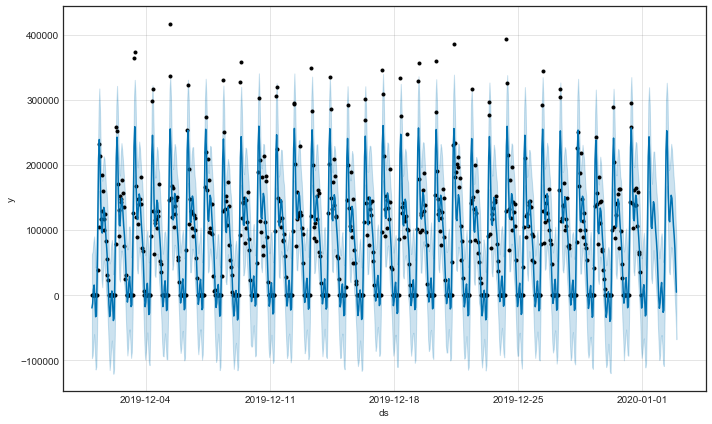

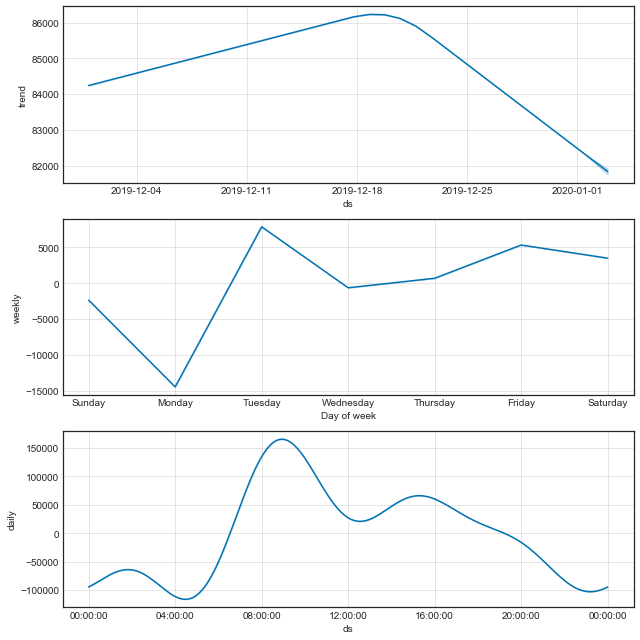

In [54]:
fb_prophet(df)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
/Users/chulgyukim/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



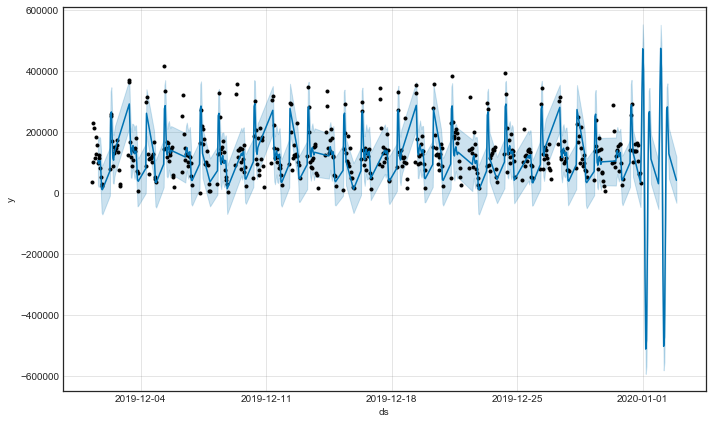

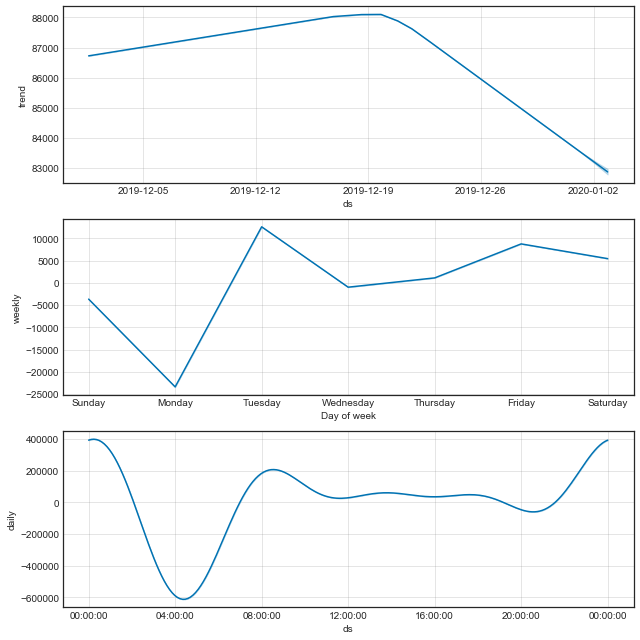

In [55]:
fb_prophet(df,(6,22))

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


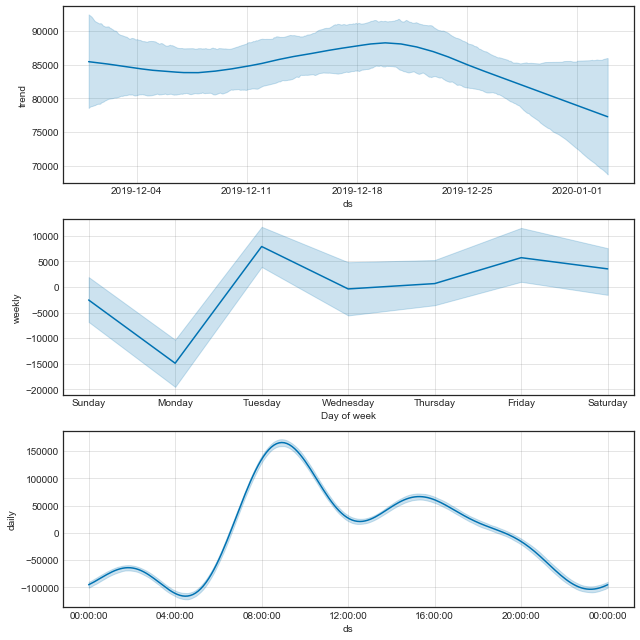

In [56]:
m1 = Prophet(mcmc_samples=100)
m1.fit(df)
future = m1.make_future_dataframe(periods=48, freq='H')
forecast = m1.predict(future)
fig = m1.plot_components(forecast)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


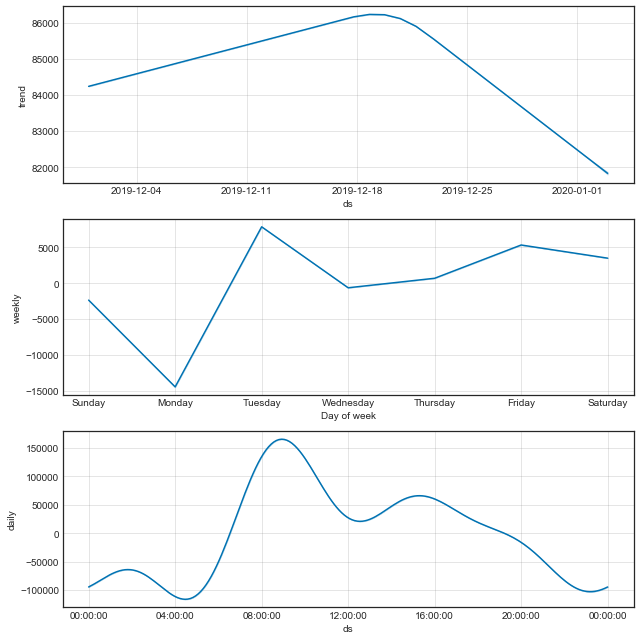

In [92]:
import holidays
m2 = Prophet()
m2.fit(df)
future2 = m2.make_future_dataframe(periods=48, freq='H')
forecast2 = m2.predict(future2)
fig = m2.plot_components(forecast2)

In [185]:
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics

df_cv = cross_validation(m2,initial ='7 days', horizon = '1 day')
df_cv.head()

INFO:fbprophet:Making 46 forecasts with cutoffs between 2019-12-08 10:00:00 and 2019-12-30 22:00:00


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2019-12-08 11:00:00,159806.442183,107689.787830,215160.073439,133000.0,2019-12-08 10:00:00
1,2019-12-08 12:00:00,111975.015763,57991.853623,161181.926436,145300.0,2019-12-08 10:00:00
2,2019-12-08 13:00:00,101168.419721,47900.480449,154878.976651,151600.0,2019-12-08 10:00:00
3,2019-12-08 14:00:00,119398.310943,68155.862568,170345.051269,107300.0,2019-12-08 10:00:00
4,2019-12-08 15:00:00,138730.961999,88804.356090,193457.306371,173200.0,2019-12-08 10:00:00


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2019-12-08 11:00:00,159806.442183,108990.835034,213225.274874,133000.0,2019-12-08 10:00:00
1,2019-12-08 12:00:00,111975.015763,60948.586013,164561.419436,145300.0,2019-12-08 10:00:00
2,2019-12-08 13:00:00,101168.419721,47788.742873,156053.883519,151600.0,2019-12-08 10:00:00
3,2019-12-08 14:00:00,119398.310943,66833.630714,171241.362904,107300.0,2019-12-08 10:00:00
4,2019-12-08 15:00:00,138730.961999,84554.421186,188964.202280,173200.0,2019-12-08 10:00:00
...,...,...,...,...,...,...
1099,2019-12-31 18:00:00,105944.224487,52335.454696,156888.016806,158000.0,2019-12-30 22:00:00
1100,2019-12-31 19:00:00,89476.255522,40057.280378,141211.770314,62800.0,2019-12-30 22:00:00
1101,2019-12-31 20:00:00,69079.689214,18589.336009,121579.346389,67000.0,2019-12-30 22:00:00
1102,2019-12-31 21:00:00,36859.282548,-17862.923316,88786.667261,35200.0,2019-12-30 22:00:00


(1104, 6)

In [102]:
df_p = performance_metrics(df_cv)
df_p.head()

INFO:fbprophet:Making 46 forecasts with cutoffs between 2019-12-08 10:00:00 and 2019-12-30 22:00:00
INFO:fbprophet:Skipping MAPE because y close to 0


,horizon,mse,rmse,mae,coverage
0,03:00:00,1.023671e+09,31994.860579,22226.609758,0.897233
1,04:00:00,1.129959e+09,33614.864587,25338.062965,0.887352
2,05:00:00,1.061469e+09,32580.199347,24793.010034,0.878656
3,06:00:00,9.410670e+08,30676.815037,24238.281389,0.896838
4,07:00:00,9.527461e+08,30866.584763,25188.498093,0.918577


In [210]:
df_p["rmse"].mean()

39891.92626960346

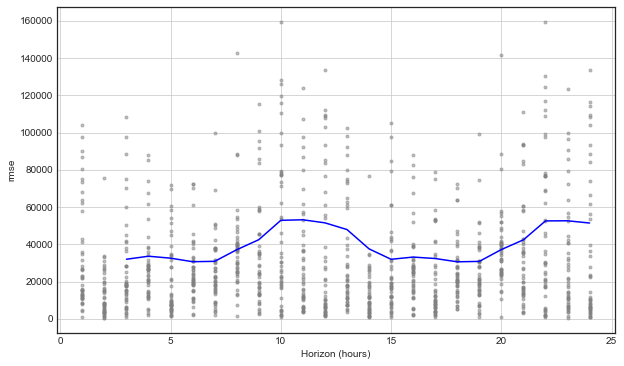

In [116]:
from fbprophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='rmse')


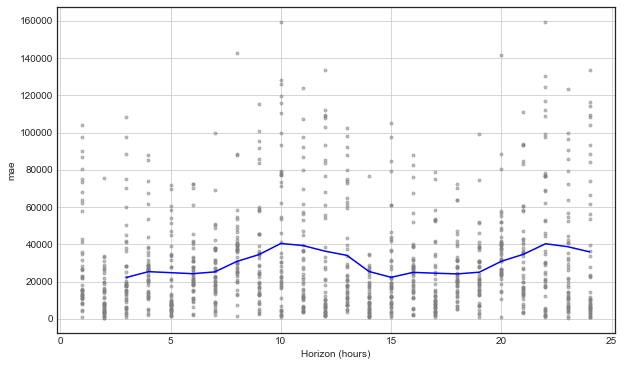

In [109]:
from fbprophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='mae')

In [125]:
# plot sales by hour for the whole year/month
    # x: every 7.am (1 hour intervals) transaction timestamp for a year/month
    # y: aggegrated sales for that timestamp hour for year/month
def simple_model(df, weekday=False, weekend=False, plot=True):
    if weekday:
        mask = (df["ds"].dt.dayofweek>0) & (df["ds"].dt.dayofweek<7)
        df = df[mask]
    elif weekend:
        mask = ((df["ds"].dt.dayofweek==0) | (df["ds"].dt.dayofweek==7))
        df = df[mask]
    # get count of each dayofweek in year
    c = Counter(df["ds"].dt.hour)
    count = np.array([x[1] for x in sorted(c.items())]) # convert to allow numpy broadcasting
#     print((df.groupby(df["ds"].dt.hour).sum()))
#     print(count)
    hourly_average = df.groupby(df["ds"].dt.hour).sum()["y"] / count
    if plot:
        hourly_average.plot()
    return hourly_average

#     # train_test_split
#     length_of_time_series = df.shape[0]
#     train_idx = int(length_of_time_series*0.8)
#     train_df = df.iloc[:train_idx]
#     test_df = df.iloc[train_idx:]
# find OLS for each day or find average horizontal line
# create simple model
    # input: an hour of the day you want to predict
    # output: the average for that hour for the year/month

ds
0          0.000000
1          0.000000
2          0.000000
3          0.000000
4          0.000000
5          0.000000
6          0.000000
7      86830.769231
8     253607.692308
9     307623.076923
10    184165.384615
11    119484.615385
12    128738.461538
13    148365.384615
14    129473.076923
15    125769.230769
16    135584.615385
17    124173.076923
18    129346.153846
19     80465.384615
20     60030.769231
21     28919.230769
22         0.000000
23         0.000000
Name: y, dtype: float64

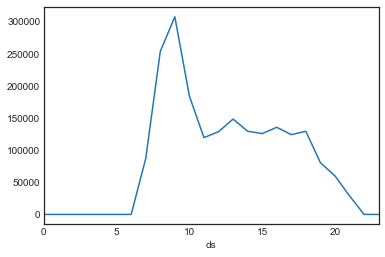

In [123]:
simple_model(df, weekday=True)

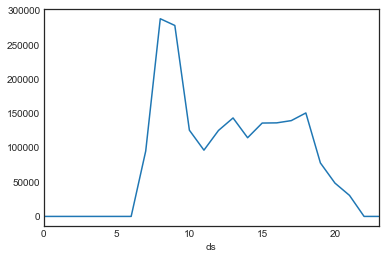

In [88]:
simple_model(df, weekend=True)

In [ ]:
# figure out metrics, scorer

In [220]:
df2 = df.copy()
df2["yhat"] = df["ds"].apply(lambda x: simple_model_df.iloc[x.hour])
#     df2["mse"] = (df2["y"] - df2["yhat"]) ** 2
#     df2["mae"] = np.abs(df2["y"] - df2["yhat"])
#     df2

In [ ]:
def simple_model_predict():
    
simple_model_predict = simple_model(df, plot=False)
simple_model_df = pd.DataFrame(simple_model_predict)

In [226]:
def simple_scorer(df):
    """calculate rmse and mae"""
    rmse = np.sqrt(((df["y"] - df["yhat"]) ** 2).mean())
    mae = np.abs(df2["y"] - df2["yhat"]).mean()
    print(f"RMSE: {rmse}")
    print(f"MAE: {mae}")

In [ ]:
# implement validation function
# fit simple model on test and simple_score() on test df
# do the same for prophet

In [228]:
simple_scorer(df2)

RMSE: 31538.03996436077
MAE: 18594.493583073192


In [ ]:
simple_scorer()